In [ ]:
# !pip install scikit-learn 

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import random 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 

In [24]:
from micrograd.engine import Value 
from micrograd.nn import Neuron, Layer, MLP 

In [5]:
np.random.seed(1337)
random.seed(1337)

In [16]:
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)
y = y*2 - 1 
print(X.shape)
print(y.shape, y.min(), y.max())

(100, 2)
(100,) -1 1


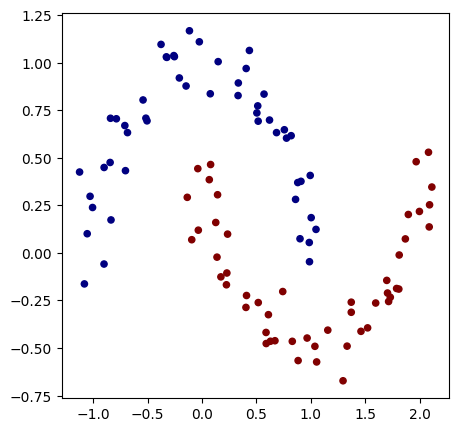

In [17]:
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='jet')

In [96]:
model = MLP(2, [16, 16, 1], 'relu') # tanh works as well. 
print(model)
print(f'number of parameters = {len(model.parameters())}')

MLP of [Layer of [reluNeuron(2), reluNeuron(2), reluNeuron(2), reluNeuron(2), reluNeuron(2), reluNeuron(2), reluNeuron(2), reluNeuron(2), reluNeuron(2), reluNeuron(2), reluNeuron(2), reluNeuron(2), reluNeuron(2), reluNeuron(2), reluNeuron(2), reluNeuron(2)], Layer of [reluNeuron(16), reluNeuron(16), reluNeuron(16), reluNeuron(16), reluNeuron(16), reluNeuron(16), reluNeuron(16), reluNeuron(16), reluNeuron(16), reluNeuron(16), reluNeuron(16), reluNeuron(16), reluNeuron(16), reluNeuron(16), reluNeuron(16), reluNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters = 337


In [97]:
def loss(batch_size=None):
    if batch_size is None:
        Xb, yb = X, y 
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]

    inputs = [list(map(Value, xrow)) for xrow in Xb]
    preds = [model(input) for input in inputs]

    # svm max-margin loss 
    losses = [(1 - yi * pred).relu() for yi, pred in zip(yb, preds)] 
    data_loss = sum(losses) / len(losses)

    # L2 regularization 
    alpha = 1e-4
    reg_loss = alpha * sum(p*p for p in model.parameters()) / len(model.parameters())

    total_loss = data_loss + reg_loss

    # accuracy 
    accuracy = sum((pred.data > 0) == (yi > 0) for pred, yi in zip(preds, yb)) / len(losses)
    return total_loss, accuracy 

total_loss, acc = loss() 
print(total_loss, acc)

Value(data=2.8614603466610373, grad=0.0) 0.5


In [98]:
# optimization 

for step in range(100):
    total_loss, acc = loss(10)
    model.zero_grad() 
    total_loss.backward() 

    learning_rate = 1.0 - 0.9*step/100 # 1.0, ..., 0.1 
    
    for p in model.parameters():
        p.data -= learning_rate * p.grad 

    if step % 1 == 0:
        print(f"step {step} loss {total_loss.data} acc {acc}")
    

step 0 loss 1.8035524576120245 acc 0.7
step 1 loss 1.365132991014083 acc 0.6
step 2 loss 3.9191390908473345 acc 0.5
step 3 loss 0.18399403568620065 acc 0.9
step 4 loss 0.25867516260248635 acc 0.9
step 5 loss 0.9437884250625189 acc 0.7
step 6 loss 0.31306995538603605 acc 0.9
step 7 loss 0.4943612282323365 acc 0.8
step 8 loss 1.2162073409518757 acc 0.7
step 9 loss 0.7948798383031054 acc 0.6
step 10 loss 0.6601572607205208 acc 0.6
step 11 loss 0.9398797543082856 acc 0.6
step 12 loss 0.19735368825300065 acc 1.0
step 13 loss 0.18955639728181356 acc 0.9
step 14 loss 0.334440084365066 acc 0.8
step 15 loss 0.5894261389768697 acc 0.8
step 16 loss 0.09967908254763039 acc 1.0
step 17 loss 0.3496683227266687 acc 0.8
step 18 loss 0.6271433900614032 acc 0.9
step 19 loss 0.14819530412624482 acc 0.9
step 20 loss 0.20343936583994202 acc 0.9
step 21 loss 0.16696828693708762 acc 0.9
step 22 loss 0.016265243383181114 acc 1.0
step 23 loss 0.30941365207105465 acc 0.9
step 24 loss 0.13249183174632037 acc 0.9

(-1.6719926036665724, 2.078007396333428)

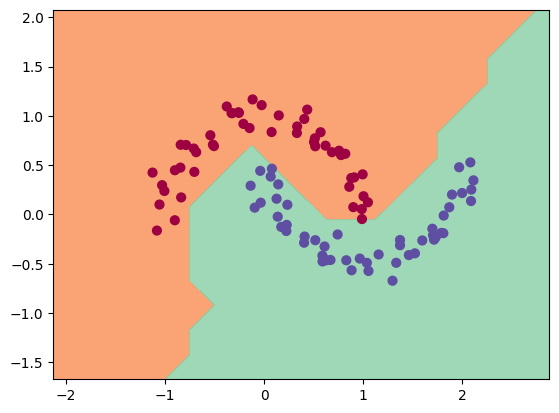

In [99]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())